In [21]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo")
import turing as tu
from turing.utils import *
import turing.loss_functions as tu_loss

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [22]:
def print_vals(name, value, actual=None):    
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
def print_model(model, D_a = 0.005, D_s = 0.2, kappa_def = 0.25, sigma_s_def= 0.02):
    
    
    sigma_s = model.losses[1].sigma_s.numpy()[0]
    rho_s = model.losses[1].rho_s.numpy()[0]

    sigma_a = model.losses[1].sigma_a.numpy()[0]
    rho_a = model.losses[1].rho_a.numpy()[0]
    mu_a = model.losses[1].mu_a.numpy()[0]
    kappa_a = model.losses[1].kappa_a.numpy()[0]



    print_vals("sigma_s", sigma_s*D_s, sigma_s_def)
    print_vals("rho_s", rho_s*D_s, 0.02)
    print()    
    print_vals("sigma_a", sigma_a*D_a, 0.0)
    print_vals("rho_a", rho_a*D_a,0.01)
    print_vals("mu_a", mu_a*D_a, 0.01 )
    print_vals("kappa_a", kappa_a, kappa_def)

In [2]:
def create_dataset(data,
                   T,
                   L,
                   training_data_size,
                   pde_data_size,
                   boundary_data_size,
                   with_boundary = True,
                   signal_to_noise = 0):
    x_domain = L*np.linspace(0,1,x_size)
    y_domain = L*np.linspace(0,1,y_size)

    X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
    XX = np.tile(X.flatten(), T) # N x T
    YY = np.tile(Y.flatten(), T) # N x T
    TT = np.repeat(t_star[-T:], N) # T x N

    AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
    SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


    x = XX[:, np.newaxis] # NT x 1
    y = YY[:, np.newaxis] # NT x 1
    t = TT[:, np.newaxis] # NT x 1

    a = AA[:, np.newaxis] # NT x 1
    s = SS[:, np.newaxis] # NT x 1

    boundary_x_LB = np.concatenate((x_domain, 
                                    np.repeat(x_domain[0], y_size)))
    boundary_x_RT = np.concatenate((x_domain, 
                                    np.repeat(x_domain[-1], y_size))) 

    boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                    y_domain))
    boundary_y_RT = np.concatenate((np.repeat(y_domain[-1], x_size),
                                    y_domain)) 

    boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
    boundary_XX_RT = np.tile(boundary_x_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
    boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
    boundary_YY_RT = np.tile(boundary_y_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
    boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_a = (np.max(AA)-np.min(AA))/2.0
        signal_amp_s = (np.max(SS)-np.min(SS))/2.0  
        sigma_a =  signal_amp_a*signal_to_noise
        sigma_s =  signal_amp_s*signal_to_noise
    # Observed data
    idx_data = np.random.choice(N*T, training_data_size, replace=False)
    # PDE colocations
    idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
    # Periodic boundary condition
    idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
    
    # Lower/Upper bounds
    lb, ub = lower_upper_bounds([np.c_[XX, YY, TT]])
    
    ret = {'obs_input': np.c_[XX[idx_data], YY[idx_data],TT[idx_data]],
           'obs_output': np.c_[AA[idx_data], SS[idx_data]],
           'pde':   np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]],
           'lb': lb,
           'ub': ub
          }
    
    if signal_to_noise > 0:        
        ret['obs_output'][0] += sigma_a * np.random.randn(len(idx_data), a.shape[1])
        ret['obs_output'][1] += sigma_s * np.random.randn(len(idx_data), s.shape[1])
    
    if with_boundary:
        ret = {**ret,
               **{'boundary_LB': np.c_[boundary_XX_LB[idx_boundary], 
                                       boundary_YY_LB[idx_boundary],
                                       boundary_TT[idx_boundary]],
                  'boundary_RT': np.c_[boundary_XX_RT[idx_boundary],
                                       boundary_YY_RT[idx_boundary],
                                       boundary_TT[idx_boundary]]
                 }
              }
    
    
    return ret    

# Dataset 1

In [3]:
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size




In [4]:
model_params_1 = {'training_data_size': T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(data, T, L,**model_params_1)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']

In [6]:
pinn = tu.NN(layers, lb, ub)
loss_stack_1 = [tu_loss.Observations(pinn, obs_X, obs_Y),
                tu_loss.ASDM(pinn, pde_X)
               ]
model_1 = tu.TINN(pinn, loss_stack_1, optimizer=keras.optimizers.Adam())

In [7]:
arr_losses_1, samples_params_1 = \
         model_1.train_experimental(20000,
                       batch_size=dataset['obs_input'].shape[0]//8, 
                       print_iter=500,
                       sample_stats = True,
                       sample_params = True,
                       init_warmup = 100,
                       observation_index = 0,
                       pde_index = 1,
                       observation_error_threshold = 1e-4,
                       gradient_ratio = 10,
                       loss_update_ratio=1.2)

Epoch: 1, loss:73792.76
Loss_observations:43157.16943359 
Loss_ASDM:30635.59155273 sigma_a:0:0.99203748, sigma_s:0:0.99200225, rho_a:0:0.99381524, rho_s:0:1.00302207, mu_a:0:1.00355315, kappa_a:0:1.00212133
Time:2.65

Epoch: 500, loss:65744.14
Loss_observations:65717.18652344 
Loss_ASDM:26.95542145 sigma_a:0:0.78129876, sigma_s:0:0.81094199, rho_a:0:0.73110110, rho_s:0:1.28033423, mu_a:0:1.24262929, kappa_a:0:1.00834215
Time:315.24

Epoch: 1000, loss:59379.09
Loss_observations:59153.50195312 
Loss_ASDM:225.59653854 sigma_a:0:0.00000000, sigma_s:0:0.51535320, rho_a:0:0.97160685, rho_s:0:0.74170983, mu_a:0:0.65649128, kappa_a:0:0.80761421
Time:333.91

Epoch: 1500, loss:12234.61
Loss_observations:11564.41735840 
Loss_ASDM:670.19649506 sigma_a:0:0.00000000, sigma_s:0:0.09139833, rho_a:0:0.83746570, rho_s:0:0.07822527, mu_a:0:0.96236140, kappa_a:0:0.12244744
Time:324.75

Epoch: 2000, loss:4631.63
Loss_observations:4110.28829956 
Loss_ASDM:521.33768845 sigma_a:0:0.00000000, sigma_s:0:0.08616

Epoch: 18500, loss:1200.74
Loss_observations:715.55178833 
Loss_ASDM:485.19000626 sigma_a:0:0.01101387, sigma_s:0:0.09037556, rho_a:0:1.83667159, rho_s:0:0.09093998, mu_a:0:1.83973587, kappa_a:0:0.25323442
Time:452.77

Epoch: 19000, loss:1221.20
Loss_observations:736.76722717 
Loss_ASDM:484.43512344 sigma_a:0:0.01305993, sigma_s:0:0.08997899, rho_a:0:1.84144366, rho_s:0:0.09088990, mu_a:0:1.84451461, kappa_a:0:0.25292584
Time:359.89

Epoch: 19500, loss:1169.25
Loss_observations:684.03926849 
Loss_ASDM:485.20642090 sigma_a:0:0.01417008, sigma_s:0:0.09022687, rho_a:0:1.84706354, rho_s:0:0.09086074, mu_a:0:1.85139883, kappa_a:0:0.25252670
Time:361.43

Epoch: 20000, loss:1194.21
Loss_observations:708.65875244 
Loss_ASDM:485.55369568 sigma_a:0:0.01517139, sigma_s:0:0.09004617, rho_a:0:1.85279965, rho_s:0:0.09099248, mu_a:0:1.85943842, kappa_a:0:0.25277999
Time:359.84



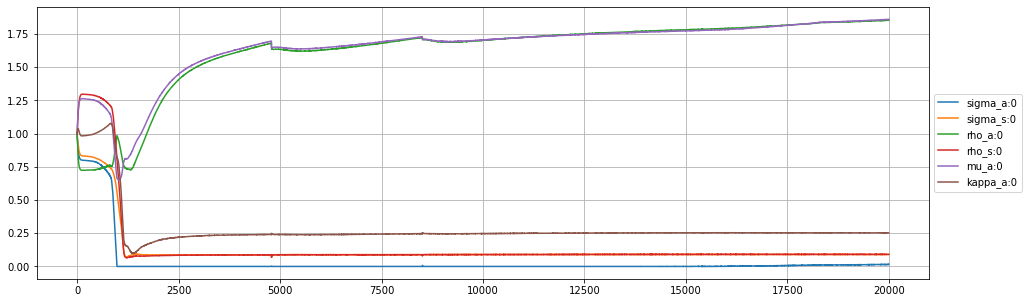

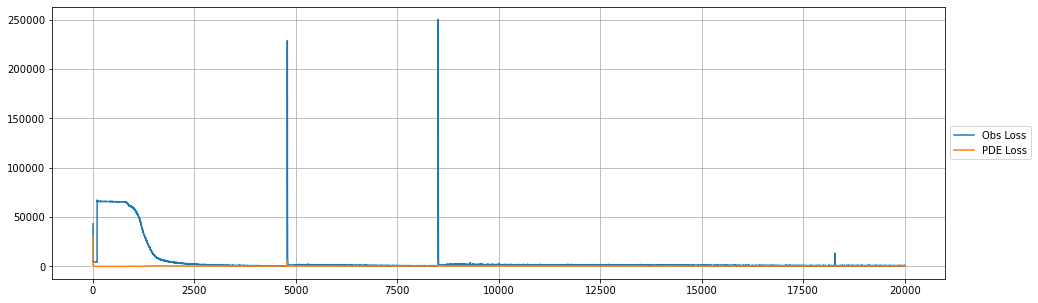

In [8]:
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_1[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,.28])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_1[start:,0], label="Obs Loss")
plt.plot(arr_losses_1[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])

plt.show()

In [9]:
print_model(model_1)

sigma_s: 0.01800923, actual: 0.020, difference: 0.00199077, relative: %9.95382518
rho_s: 0.01819850, actual: 0.020, difference: 0.00180150, relative: %9.00751948

sigma_a: 0.00007586, actual: 0.000, difference: 0.00007586 
rho_a: 0.00926400, actual: 0.010, difference: 0.00073600, relative: %7.36001730
mu_a: 0.00929719, actual: 0.010, difference: 0.00070281, relative: %7.02807903
kappa_a: 0.25277999, actual: 0.250, difference: 0.00277999, relative: %1.11199617


# Dataset 2

In [10]:
data_path = os.path.abspath("turing_sigma_s_0_02_kappa_0.npy")
with open(data_path, 'rb') as f:
    data2 = np.load(f)
    
data_path = os.path.abspath("turing_t_sigma_s_0_02_kappa_0.npy")
with open(data_path, 'rb') as f:
    t_star2 = np.load(f) 
    
T2 = t_star2.shape[0]    
    
L2 = 50
x_size2 = data2.shape[1]
y_size2 = data2.shape[2]
N2 = x_size2*y_size2


In [11]:
model_params_2 = {'training_data_size': T2*32,
                'pde_data_size': (T2*N2)//(32),
                'boundary_data_size':((x_size2 + y_size2)*T2)//(8)}

dataset2 = create_dataset(data2, T2, L2,**model_params_2)
lb2 = dataset2['lb']
ub2 = dataset2['ub']
obs_X2 = dataset2['obs_input']
obs_Y2 = dataset2['obs_output']
pde_X2 = dataset2['pde']

In [12]:
pinn2 = tu.NN(layers, lb2, ub2)
loss_stack_2 = [tu_loss.Observations(pinn2, obs_X2, obs_Y2),
                tu_loss.ASDM(pinn2, pde_X2)
               ]
model_2 = tu.TINN(pinn2, loss_stack_2, optimizer=keras.optimizers.Adam())

In [13]:
arr_losses_2, samples_params_2 = \
         model_2.train_experimental(20000,
                       batch_size=dataset2['obs_input'].shape[0]//8, 
                       print_iter=500,
                       sample_stats = True,
                       sample_params = True,
                       init_warmup = 50,
                       observation_index = 0,
                       pde_index = 1,
                       observation_error_threshold = 1e-4,
                       gradient_ratio = 10,
                       loss_update_ratio=1.2)

Epoch: 1, loss:68493.22
Loss_observations:38601.70849609 
Loss_ASDM:29891.51879883 sigma_a:0:0.99205494, sigma_s:0:0.99200237, rho_a:0:0.99781168, rho_s:0:1.00240445, mu_a:0:1.00475562, kappa_a:0:0.99408877
Time:1.87

Epoch: 500, loss:370143.16
Loss_observations:370074.83203125 
Loss_ASDM:68.33126926 sigma_a:0:0.69653082, sigma_s:0:0.61062592, rho_a:0:0.85993570, rho_s:0:1.28174186, mu_a:0:1.10376894, kappa_a:0:0.69634181
Time:323.78

Epoch: 1000, loss:241470.38
Loss_observations:239065.04687500 
Loss_ASDM:2405.31910706 sigma_a:0:0.00000000, sigma_s:0:0.06780713, rho_a:0:0.76221627, rho_s:0:0.07249776, mu_a:0:0.65820754, kappa_a:0:0.00000000
Time:324.17

Epoch: 1500, loss:60470.35
Loss_observations:45902.83154297 
Loss_ASDM:14567.51586914 sigma_a:0:0.00000000, sigma_s:0:0.09790309, rho_a:0:1.69459307, rho_s:0:0.09449363, mu_a:0:1.67357767, kappa_a:0:0.00000000
Time:327.07

Epoch: 2000, loss:38079.48
Loss_observations:25050.27783203 
Loss_ASDM:13029.19738770 sigma_a:0:0.00000000, sigma_

Epoch: 18500, loss:116900.77
Loss_observations:86581.50195312 
Loss_ASDM:30319.26513672 sigma_a:0:0.26082754, sigma_s:0:0.10643080, rho_a:0:2.79319572, rho_s:0:0.10456289, mu_a:0:3.03402495, kappa_a:0:0.00162263
Time:369.71

Epoch: 19000, loss:114485.39
Loss_observations:83175.90429688 
Loss_ASDM:31309.48144531 sigma_a:0:0.26192966, sigma_s:0:0.10627183, rho_a:0:2.80120373, rho_s:0:0.10414926, mu_a:0:3.04040337, kappa_a:0:0.00160477
Time:372.43

Epoch: 19500, loss:107438.29
Loss_observations:76570.23632812 
Loss_ASDM:30868.05688477 sigma_a:0:0.26117596, sigma_s:0:0.10704040, rho_a:0:2.80902100, rho_s:0:0.10528892, mu_a:0:3.04829836, kappa_a:0:0.00225054
Time:373.47

Epoch: 20000, loss:114886.52
Loss_observations:83890.69921875 
Loss_ASDM:30995.82446289 sigma_a:0:0.26139268, sigma_s:0:0.10752778, rho_a:0:2.81695628, rho_s:0:0.10477836, mu_a:0:3.05518341, kappa_a:0:0.00182810
Time:376.21



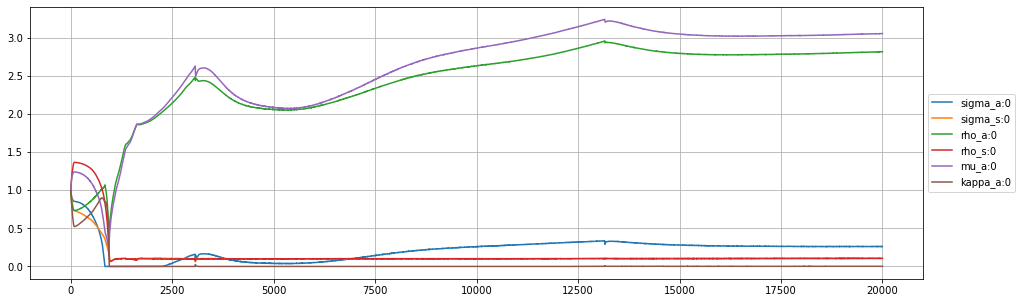

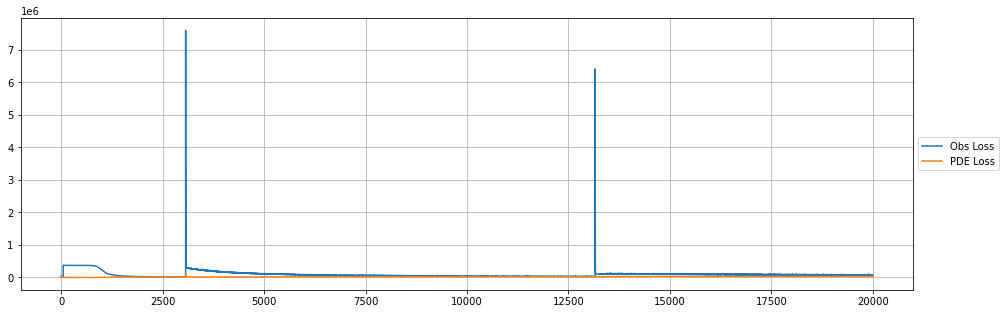

In [14]:
param_names = [v.name for v in loss_stack_2[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_2[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,.28])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_2[start:,0], label="Obs Loss")
plt.plot(arr_losses_2[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])

plt.show()

In [15]:
print_model(model_1)

sigma_s: 0.01800923, actual: 0.020, difference: 0.00199077, relative: %9.95382518
rho_s: 0.01819850, actual: 0.020, difference: 0.00180150, relative: %9.00751948

sigma_a: 0.00007586, actual: 0.000, difference: 0.00007586 
rho_a: 0.00926400, actual: 0.010, difference: 0.00073600, relative: %7.36001730
mu_a: 0.00929719, actual: 0.010, difference: 0.00070281, relative: %7.02807903
kappa_a: 0.25277999, actual: 0.250, difference: 0.00277999, relative: %1.11199617


# Dataset 3

In [16]:
data_path = os.path.abspath("turing_sigma_s_0_03_kappa_0.npy")
with open(data_path, 'rb') as f:
    data3 = np.load(f)
    
data_path = os.path.abspath("turing_t_sigma_s_0_03_kappa_0.npy")
with open(data_path, 'rb') as f:
    t_star3 = np.load(f) 
    
T3 = t_star3.shape[0]    
    
L3 = 50
x_size3 = data3.shape[1]
y_size3 = data3.shape[2]
N3 = x_size3*y_size3


In [17]:
model_params_3 = {'training_data_size': T3*32,
                'pde_data_size': (T3*N3)//(32),
                'boundary_data_size':((x_size3 + y_size3)*T3)//(8)}

dataset3 = create_dataset(data3, T3, L3, **model_params_3)
lb3 = dataset3['lb']
ub3 = dataset3['ub']
obs_X3 = dataset3['obs_input']
obs_Y3 = dataset3['obs_output']
pde_X3 = dataset3['pde']

In [18]:
pinn3 = tu.NN(layers, lb3, ub3)
loss_stack_3 = [tu_loss.Observations(pinn3, obs_X3, obs_Y3),
                tu_loss.ASDM(pinn3, pde_X3)
               ]
model_3 = tu.TINN(pinn3, loss_stack_3, optimizer=keras.optimizers.Adam())

In [ ]:
arr_losses_3, samples_params_3 = \
         model_3.train_experimental(20000,
                       batch_size=dataset3['obs_input'].shape[0]//8, 
                       print_iter=500,
                       sample_stats = True,
                       sample_params = True,
                       init_warmup = 100,
                       observation_index = 0,
                       pde_index = 1,
                       observation_error_threshold = 1e-4,
                       gradient_ratio = 10,
                       loss_update_ratio=1.2)

Epoch: 1, loss:77145.56
Loss_observations:47521.32275391 
Loss_ASDM:29624.23559570 sigma_a:0:0.99206787, sigma_s:0:0.99200183, rho_a:0:0.99581969, rho_s:0:1.00661254, mu_a:0:1.00228822, kappa_a:0:0.99536961
Time:1.84

Epoch: 500, loss:178346.66
Loss_observations:178314.30078125 
Loss_ASDM:32.37002897 sigma_a:0:0.92431277, sigma_s:0:0.77340961, rho_a:0:0.92004704, rho_s:0:1.30862761, mu_a:0:0.97828400, kappa_a:0:0.65095460
Time:329.62

Epoch: 1000, loss:177892.58
Loss_observations:177866.32617188 
Loss_ASDM:26.25199676 sigma_a:0:0.69432163, sigma_s:0:0.73108333, rho_a:0:0.82463652, rho_s:0:1.24089432, mu_a:0:0.78813237, kappa_a:0:0.65311772
Time:331.43

Epoch: 1500, loss:177924.58
Loss_observations:177906.19335938 
Loss_ASDM:18.39201379 sigma_a:0:0.42241254, sigma_s:0:0.66842049, rho_a:0:0.71291101, rho_s:0:1.16353118, mu_a:0:0.55637187, kappa_a:0:0.68270731
Time:335.23

Epoch: 2000, loss:177601.58
Loss_observations:177593.63281250 
Loss_ASDM:7.94196719 sigma_a:0:0.17056914, sigma_s:0:0

Epoch: 18500, loss:42172.84
Loss_observations:33149.61791992 
Loss_ASDM:9023.22009277 sigma_a:0:0.75690782, sigma_s:0:0.15719661, rho_a:0:3.33309221, rho_s:0:0.10466963, mu_a:0:3.83897448, kappa_a:0:0.00000000
Time:367.89

Epoch: 19000, loss:43744.19
Loss_observations:34652.36401367 
Loss_ASDM:9091.82104492 sigma_a:0:0.76562184, sigma_s:0:0.15739851, rho_a:0:3.34762621, rho_s:0:0.10457817, mu_a:0:3.86078405, kappa_a:0:0.00000000
Time:368.00



In [ ]:
param_names = [v.name for v in loss_stack_3[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_3[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,.28])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_3[start:,0], label="Obs Loss")
plt.plot(arr_losses_3[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])

plt.show()

In [ ]:
print_model(model_3)

# Dataset 4

In [26]:
data_path = os.path.abspath("turing_model_2.npy")
with open(data_path, 'rb') as f:
    data4 = np.load(f)
    
data_path = os.path.abspath("turing_t_model_2.npy")
with open(data_path, 'rb') as f:
    t_star4 = np.load(f) 
    
T4 = t_star4.shape[0]    
    
L4 = 50
x_size4 = data4.shape[1]
y_size4 = data4.shape[2]
N4 = x_size4*y_size4

In [27]:
model_params_4 = {'training_data_size': T4*32,
                'pde_data_size': (T4*N4)//(32),
                'boundary_data_size':((x_size4 + y_size4)*T4)//(8)}

dataset4 = create_dataset(data4, T4, L4, **model_params_4)
lb4 = dataset4['lb']
ub4 = dataset4['ub']
obs_X4 = dataset4['obs_input']
obs_Y4 = dataset4['obs_output']
pde_X4 = dataset4['pde']

In [35]:
class schnakenberg(tu_loss.Truing_PDE):
    def __init__(self, 
                 pinn, 
                 inputs_pde, 
                 init_loss_weight = 1.0,
                 c_0 = 10.0,
                 c_1 = 10.0,
                 c_2 = 10.0,
                 c_3 = 10.0,
                 c_4 = 10.0
                ):
        super().__init__(pinn, inputs_pde, name="Loss_ASDM", init_loss_weight= init_loss_weight)
        
        self.c_0 = tf.Variable([c_0], dtype=tf.float32,
                                   name="c_0",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.c_1 = tf.Variable([c_1], dtype=tf.float32, 
                                   name="c_1",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.c_2 = tf.Variable([c_2], dtype=tf.float32, 
                                name="c_2",
                                constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.c_3 = tf.Variable([c_3], dtype=tf.float32, 
                                 name="c_3",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
        self.c_4 = tf.Variable([c_4], dtype=tf.float32, 
                                 name="c_4",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
        
    def trainable_vars(self):
        return [self.c_0,
                self.c_1,                
                self.c_2,
                self.c_3,
                self.c_4]
        
    def pde(self, outputs, partials_1, partials_2):
        u = outputs[:, 0]
        v = outputs[:, 1]
        
        u_x = partials_1[0][:, 0]
        u_y = partials_1[0][:, 1]
        u_t = partials_1[0][:, 2]
        
        u_xx = partials_2[0][:, 0]
        u_yy = partials_2[0][:, 1]
        
        
        v_x = partials_1[1][:, 0]
        v_y = partials_1[1][:, 1]
        v_t = partials_1[1][:, 2]
        
        v_xx = partials_2[1][:, 0]
        v_yy = partials_2[1][:, 1]
        
        c_0 = self.c_0
        c_1 = self.c_1
        c_2 = self.c_2
        c_3 = self.c_3
        c_4 = self.c_4
        
        
        u2v = u*u*v
        f_u = u_t - (u_xx + u_yy) + c_1 - c_0*u + c_3 * u2v
        f_v = v_t - (v_xx + v_yy) + c_2 - c_4 * u2v
        
        return tf.concat([tf.expand_dims(f_u, axis=1), 
                          tf.expand_dims(f_v, axis=1)], axis = 1)

In [36]:
pinn4 = tu.NN(layers, lb4, ub4)
loss_stack_4 = [tu_loss.Observations(pinn4, obs_X4, obs_Y4),
                schnakenberg(pinn4, pde_X4)
               ]
model_4 = tu.TINN(pinn4, loss_stack_4, optimizer=keras.optimizers.Adam())

In [37]:
arr_losses_4, samples_params_4 = \
         model_4.train_experimental(20000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       sample_stats = True,
                       sample_params = True,
                       init_warmup = 200,
                       observation_index = 0,
                       pde_index = 1,
                       observation_error_threshold = 1e-3,
                       gradient_ratio = 10,
                       loss_update_ratio=1.2)

Epoch: 1, loss:2986351.00
Loss_observations:39475.95947266 
Loss_ASDM:2946875.15625000 c_0:0:10.00405407, c_1:0:9.99206924, c_2:0:9.99199677, c_3:0:9.99727345, c_4:0:9.99775791
Time:2.01

Epoch: 100, loss:35603.52
Loss_observations:34992.05908203 
Loss_ASDM:611.45793152 c_0:0:10.23461533, c_1:0:9.91544533, c_2:0:9.93091488, c_3:0:9.79419136, c_4:0:10.23151112
Time:87.25

Epoch: 200, loss:31336.79
Loss_observations:31006.67285156 
Loss_ASDM:330.12062073 c_0:0:10.57722092, c_1:0:9.80066204, c_2:0:9.86711693, c_3:0:9.45847893, c_4:0:10.59380531
Time:84.80

Epoch: 300, loss:336214.25
Loss_observations:330688.59765625 
Loss_ASDM:5525.66961670 c_0:0:11.72998238, c_1:0:8.86399651, c_2:0:9.35690784, c_3:0:8.26481819, c_4:0:11.66288853
Time:77.31

Epoch: 400, loss:312734.47
Loss_observations:311120.38281250 
Loss_ASDM:1614.10862732 c_0:0:12.23312569, c_1:0:8.33195019, c_2:0:9.07667542, c_3:0:7.71813822, c_4:0:12.06885242
Time:73.13

Epoch: 500, loss:306661.97
Loss_observations:306330.86328125 


Epoch: 4400, loss:43888.61
Loss_observations:28231.59741211 
Loss_ASDM:15657.01147461 c_0:0:2.70103121, c_1:0:0.19204789, c_2:0:0.66127211, c_3:0:9.95846748, c_4:0:2.74381900
Time:78.19

Epoch: 4500, loss:35318.01
Loss_observations:23166.62915039 
Loss_ASDM:12151.37829590 c_0:0:2.77432966, c_1:0:0.22587729, c_2:0:0.53361601, c_3:0:9.35046959, c_4:0:2.02989006
Time:80.11

Epoch: 4600, loss:27150.61
Loss_observations:18741.93920898 
Loss_ASDM:8408.66857910 c_0:0:3.02379251, c_1:0:0.32547855, c_2:0:0.39320165, c_3:0:8.71156788, c_4:0:1.29685080
Time:79.42

Epoch: 4700, loss:20392.95
Loss_observations:14937.62194824 
Loss_ASDM:5455.32513428 c_0:0:3.40104890, c_1:0:0.48239791, c_2:0:0.21940692, c_3:0:8.04016399, c_4:0:0.60440099
Time:81.17

Epoch: 4800, loss:15750.65
Loss_observations:12135.09521484 
Loss_ASDM:3615.55941772 c_0:0:3.81449318, c_1:0:0.68108070, c_2:0:0.04838814, c_3:0:7.39650536, c_4:0:0.10796268
Time:78.65

Epoch: 4900, loss:13035.35
Loss_observations:9871.10278320 
Loss_ASD

Epoch: 8900, loss:7390.27
Loss_observations:4229.90405273 
Loss_ASDM:3160.36953735 c_0:0:2.15654469, c_1:0:0.70940298, c_2:0:0.00000000, c_3:0:2.04960608, c_4:0:0.00000000
Time:83.42

Epoch: 9000, loss:7702.97
Loss_observations:4260.74206543 
Loss_ASDM:3442.23077393 c_0:0:2.17241621, c_1:0:0.71422654, c_2:0:0.00000000, c_3:0:2.06578946, c_4:0:0.00000000
Time:88.61

Epoch: 9100, loss:21112.82
Loss_observations:16888.31787109 
Loss_ASDM:4224.50347900 c_0:0:2.17188454, c_1:0:0.77970910, c_2:0:0.00125147, c_3:0:1.71949816, c_4:0:0.00000000
Time:87.95

Epoch: 9200, loss:19394.06
Loss_observations:15357.96142578 
Loss_ASDM:4036.09484863 c_0:0:1.87460423, c_1:0:0.71521425, c_2:0:0.00187746, c_3:0:1.40298975, c_4:0:0.00000000
Time:84.23

Epoch: 9300, loss:19023.02
Loss_observations:15198.42163086 
Loss_ASDM:3824.60092163 c_0:0:1.49738383, c_1:0:0.62462932, c_2:0:0.00084790, c_3:0:1.03307021, c_4:0:0.00000000
Time:79.81

Epoch: 9400, loss:17888.88
Loss_observations:14394.53521729 
Loss_ASDM:349

Epoch: 13400, loss:6374.27
Loss_observations:3967.49053955 
Loss_ASDM:2406.78289795 c_0:0:0.29189575, c_1:0:0.29252094, c_2:0:0.00000000, c_3:0:0.00000000, c_4:0:0.00000000
Time:87.30

Epoch: 13500, loss:6231.10
Loss_observations:3795.32208252 
Loss_ASDM:2435.78088379 c_0:0:0.29111600, c_1:0:0.29354665, c_2:0:0.00000000, c_3:0:0.00000000, c_4:0:0.00000000
Time:90.09

Epoch: 13600, loss:6191.46
Loss_observations:3743.83020020 
Loss_ASDM:2447.62814331 c_0:0:0.29283723, c_1:0:0.29248792, c_2:0:0.00000000, c_3:0:0.00000000, c_4:0:0.00000000
Time:86.29

Epoch: 13700, loss:6002.34
Loss_observations:3550.15591431 
Loss_ASDM:2452.18252563 c_0:0:0.29211751, c_1:0:0.29229969, c_2:0:0.00000000, c_3:0:0.00000000, c_4:0:0.00000000
Time:86.67

Epoch: 13800, loss:5963.40
Loss_observations:3508.16574097 
Loss_ASDM:2455.23132324 c_0:0:0.29155543, c_1:0:0.29192117, c_2:0:0.00000000, c_3:0:0.00000000, c_4:0:0.00000000
Time:87.93

Epoch: 13900, loss:6315.41
Loss_observations:3849.35427856 
Loss_ASDM:2466.

Epoch: 17900, loss:6403.36
Loss_observations:3826.43817139 
Loss_ASDM:2576.92178345 c_0:0:0.28902632, c_1:0:0.28861514, c_2:0:0.00000000, c_3:0:0.00000000, c_4:0:0.00000000
Time:86.85

Epoch: 18000, loss:6323.05
Loss_observations:3761.93188477 
Loss_ASDM:2561.11907959 c_0:0:0.28876224, c_1:0:0.28829098, c_2:0:0.00000000, c_3:0:0.00000000, c_4:0:0.00000000
Time:86.87

Epoch: 18100, loss:7948.39
Loss_observations:5391.47491455 
Loss_ASDM:2556.91375732 c_0:0:0.28914973, c_1:0:0.28869018, c_2:0:0.00000000, c_3:0:0.00000000, c_4:0:0.00000000
Time:86.53

Epoch: 18200, loss:7530.24
Loss_observations:4967.13381958 
Loss_ASDM:2563.10348511 c_0:0:0.28898677, c_1:0:0.28869829, c_2:0:0.00000000, c_3:0:0.00000000, c_4:0:0.00000000
Time:89.16

Epoch: 18300, loss:7089.70
Loss_observations:4528.14434814 
Loss_ASDM:2561.55380249 c_0:0:0.28840294, c_1:0:0.28895822, c_2:0:0.00000000, c_3:0:0.00000000, c_4:0:0.00000000
Time:92.75

Epoch: 18400, loss:6795.71
Loss_observations:4240.28201294 
Loss_ASDM:2555.


- $c_0 = 1$
- $c_1 = 0.1$
- $c_2 = 0.9/40 = 0.0225$
- $c_3 = 1$
- $c_4 = 1/40 = 0.025$

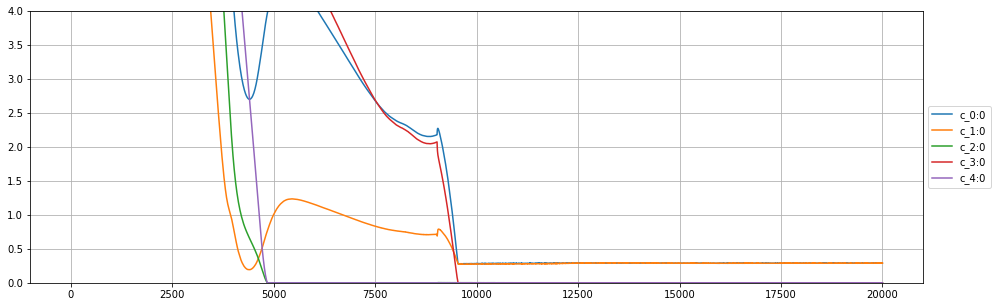

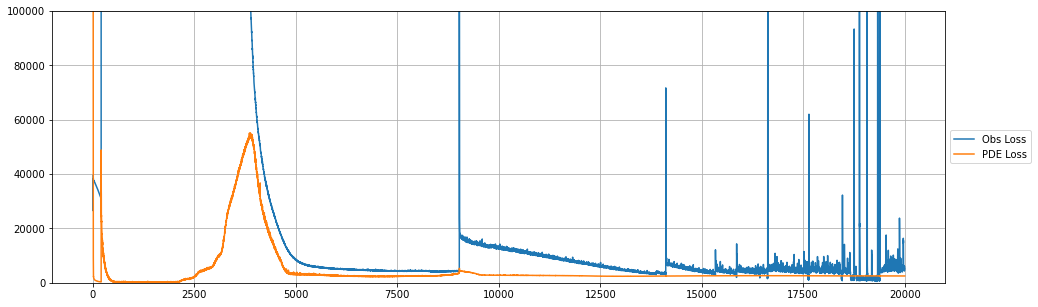

In [44]:
param_names = [v.name for v in loss_stack_4[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_4[start:,j], label=f"{param_names[j]}")

plt.ylim([0,4])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_4[start:,0], label="Obs Loss")
plt.plot(arr_losses_4[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,100000])

plt.show()

In [46]:
pinn5 = tu.NN(layers, lb4, ub4)
loss_stack_5 = [tu_loss.Observations(pinn5, obs_X4, obs_Y4),
                schnakenberg(pinn5, pde_X4)
               ]
model_5 = tu.TINN(pinn5, loss_stack_5, optimizer=keras.optimizers.Adam())

In [ ]:
arr_losses_5, samples_params_5, _ = \
         model_5.train(10000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold=0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:2982281.75
Loss_observations:39251.30908203 
Loss_ASDM:2943030.31250000 c_0:0:10.00477600, c_1:0:9.99207211, c_2:0:9.99199677, c_3:0:10.00690365, c_4:0:9.99523449
Time:2.00

Epoch: 100, loss:35328.19
Loss_observations:34690.57226562 
Loss_ASDM:637.61598969 c_0:0:10.26501179, c_1:0:9.91569328, c_2:0:9.93156624, c_3:0:9.77466679, c_4:0:10.26056290
Time:83.95

Epoch: 200, loss:30802.65
Loss_observations:30467.57885742 
Loss_ASDM:335.06802368 c_0:0:10.64358044, c_1:0:9.80109406, c_2:0:9.86751461, c_3:0:9.40754128, c_4:0:10.65491962
Time:84.71

Epoch: 300, loss:27025.25
Loss_observations:26842.92895508 
Loss_ASDM:182.32253456 c_0:0:11.06381989, c_1:0:9.64605904, c_2:0:9.79126930, c_3:0:8.98212719, c_4:0:11.05436039
Time:82.37

Epoch: 400, loss:24233.38
Loss_observations:24072.72143555 
Loss_ASDM:160.65816689 c_0:0:11.48859024, c_1:0:9.45627689, c_2:0:9.70988369, c_3:0:8.53514385, c_4:0:11.41703987
Time:83.63

Epoch: 500, loss:22198.72
Loss_observations:22131.85107422 
Loss_AS

In [49]:
dataset4['obs_input'].shape[0]

16384